# Training deep learning classifiers of enzymatic substrate preferences from mRNA display NGS data

This notebook walks through the process of using the code in this repo to parse and preprocess NGS data, and then to train a deep learning classifier of substrate prerefences. See also the accompanying manuscript.

The minimal viable workflow will be shown, where round 5 selection/antiselection data for LazDEF are used to train a CNN classifier of substrate fitness.

### 1. Import prerequisites. 

config holds all metaparameters needed to execute the pipeline, namely: the information about library design as sequenced (for library 6C6), location of data, preprocessing details and model hyperparameters.

In [1]:
import config

from utils.processhandlers import Pipeline, FastqParser, DataPreprocessor
from utils.dispatcher import Dispatcher
from utils.classifier import Classifier

### 2. Initialize data handler objects: Pipeline, Parser, Preprocessor and Classifier

In [2]:
dispatcher = Dispatcher(config)
handlers = (Pipeline, FastqParser, DataPreprocessor, Classifier)
pip, par, pre, cla = dispatcher.dispatch_handlers(handlers)

[INFO]: The following handler was succesfully initialized: <Pipeline object; current queue size: 0 routine(s)>
[INFO]: The following handler was succesfully initialized: <FastqParser object>
[INFO]: The following handler was succesfully initialized: <DataPreprocessor object>
[INFO]: Classifier succesfully initialized <LazDEF_model_test> model.
[INFO]: The following handler was succesfully initialized: <Classifier object>


The model is also initialized at this stage:

In [3]:
cla.model.summary()

Model: "LazDEF_model_test"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 208)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 12, 104)      65000       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 12, 104)      43368       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 12, 104)      86632       input_1[0][0]                    
__________________________________________________________________________________

The model architecture is specified in config. In this case, the model comes from "code/tf/cnn_model.py" <br>
It is not yet compiled:

In [4]:
cla.model._is_compiled

False

### 3. Build the pipeline by queueing ops to run on data as follows:

In [5]:
pip.enque([
            par.fetch_gz_from_dir(), 
            par.translate(force_at_frame=0),         
            par.len_filter(where='pep'),               
            par.cr_filter(where='pep', loc=[0, 4], tol=4),
            par.cr_filter(where='pep', loc=[2], tol=0),
            par.q_score_filt(minQ=30, loc=[1, 3]),
            par.fetch_at(where='pep', loc=[1, 3]),
            par.filt_ambiguous(where='pep'),
            par.unpad(),
            par.save(where='pep', fmt='npy'),
            pre.label_sequencing_samples(sele_name='66_r5_sele', anti_name='66_r5_anti'),
            pre.int_repr(),
            pre.pop_intraset(),
            pre.pop_interset(),
            pre.merge(),
            pre.shuffle(),
            pre.tt_split(test_fraction=0.05),
            pre.to_h5(reshape=True, repad=False, chunks=100, return_data=False),       
            cla.fit()
         ])

[INFO]: 19 routines appended to pipeline; current queue size: 19


At this stage, no operations on data take place just yet, but the basic validity of specified ops is asserted. For documentation on FastqParser's operation refer to https://github.com/avngrdv/FastqProcessor. Parser will first fetch NGS .fastq files (as .gz; '66_r5_sele.gz' for LazDEF selection round 5 data, and '66_r5_anti.gz' for the antiselection) from the directory specified in config (in this case, it's "../sequencing_data"). NGS data was uploaded to DDBJ and will be made available upon publication.

The parser will perform in silico translation, and filter the resulting sequence lists (length filter, constant region, Q-score). Finally, peptide sequences will be truncated to keep only variable regions, and the data will be saved as .npy files. The location of parser outputs is also specified in config ("../parser_outputs" in this case). <br><br> DataPreprocessor will then label the resulting lists (selection peptides receive label 1, antiselection - 0), remove duplicates, merge/shuffle the datasets, split into training and test sets, and finally featurize the peptides. The featurization matrix needs to be specified in config; else peptides will be one-hot encoded. In this case, a featurization matrix is stored at "../feature_matrices/DENSE_Morgan_F_r=4_LazDEF.npy". A number of feature matrix generators are available in code/utils/feature_matrix_generators.py <br><br> Note that in this case, ECFP representations will be used, which will produce ~80 Gb datasets that (on my machine) cannot be stored in memory. Hence, DataPreprocessor.to_h5 featurization method is used to dump feauturized datasets to .hdf5 files. The .hdf5 datasets will be stored in "../ml_data/train_data.hdf5" and "../ml_data/test_data.hdf5" as specified in config <br><br>

### 4. Execute the queue as shown below

The ops, executed one by one, will sequentially transform the data to prepare it for deep learning. The last op, cla.fit(), will train the model (training hyperparameters are specified in config). Here, we will only train for 2 epochs for speed.

par.translate(), pre.to_h5() and cla.fit() make take a while, other ops are reasonably fast.
Pipeline verbosity can be controlled by config.ParserConfig.verbosity and config.ParserConfig.level parameters

In [6]:
pip.run(save_summary=True)

[INFO]: Queuing <fetch_dir_gz> routine. . .
[INFO]: Fetching 66_r5_anti.gz. . .
[INFO]: Fetching 66_r5_sele.gz. . .
[INFO]: The operation took 38.964 s
[INFO]: 66_r5_anti DNA dataset shape: (7156118,)
[INFO]: 66_r5_anti Q score dataset shape: (7156118,)
[INFO]: 66_r5_anti Peptide dataset shape: None
[INFO]: 66_r5_sele DNA dataset shape: (7751474,)
[INFO]: 66_r5_sele Q score dataset shape: (7751474,)
[INFO]: 66_r5_sele Peptide dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <translate_dna> routine. . .
[INFO]: The operation took 476.644 s
[INFO]: 66_r5_anti DNA dataset shape: (7156118, 151)
[INFO]: 66_r5_anti Q score dataset shape: (7156118, 151)
[INFO]: 66_r5_anti Peptide dataset shape: (7156118, 52)
[INFO]: 66_r5_sele DNA dataset shape: (7751474, 151)
[INFO]: 66_r5_sele Q score dataset shape: (7751474, 151)
[INFO]: 66_r5_sele Peptide dataset shape: (7751474, 52)
[INFO]: ------------------------------------------------------

Epoch 1/2
3823/3823 [==============================] - 212s 54ms/step - loss: 0.1765 - accuracy: 0.9158 - val_loss: 0.0355 - val_accuracy: 0.9894
Epoch 2/2
3823/3823 [==============================] - 205s 54ms/step - loss: 0.0383 - accuracy: 0.9880 - val_loss: 0.0315 - val_accuracy: 0.9910


[INFO]: The operation took 417.792 s


The model has now been compiled and trained, scoring 0.988 test accuracy in just two epochs - not bad. 

In [7]:
cla.model._is_compiled

True

Let's reproduce Fig. 5f results, that is, use the model to estimate the degree of epistasis in LazDEF substrates. To do this, we in silico generate some library 6C6 peptides (1M in this example to save time; 5M in the paper), and predict their modification efficiency with the model:

In [8]:
from utils.misc import sample_random_peptides, compute_pairwise_epistasis 
P = sample_random_peptides(1000000, 12, config.constants.aas)

print(f'Array shape: {P.shape}')
print('Example peptide: ', ''.join(x for x in P[0]))

Array shape: (1000000, 12)
Example peptide:  QNSQEHVEAWVH


Note that the middle Cys (Cys7) is missing - LazDEF models were trained using the sequence information from amino acids 1-6 and 8-13 (which is reflected in the par.fetch_at(where='pep', loc=[1, 3]) call above).

Either way, the peptides need to be properly represented for the model

In [9]:
from utils.datatypes import Data, TrainingSample
data = Data([TrainingSample(X=P, y=None, name='1M_random_peptides')])

pip.enque([pre.int_repr()])
data = pip.run(data)

P_num_repr = data['1M_random_peptides'].X
pip.enque([
           pre.featurize_X(reshape=True, repad=False),
           cla.predict(flatten_results=True)
          ])

data = pip.run(data)

[INFO]: 1 routines appended to pipeline; current queue size: 1
[INFO]: 1M_random_peptides X dataset shape: (1000000, 12)
[INFO]: 1M_random_peptides y dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <numerical_repr> routine. . .
[INFO]: The operation took 1.631 s
[INFO]: 1M_random_peptides X dataset shape: (1000000, 12)
[INFO]: 1M_random_peptides y dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: 2 routines appended to pipeline; current queue size: 2
[INFO]: 1M_random_peptides X dataset shape: (1000000, 12)
[INFO]: 1M_random_peptides y dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <factorize_X_datasets> routine. . .
[INFO]: The operation took 7.079 s
[INFO]: 1M_random_peptides X dataset shape: (1000000, 12, 208)
[INFO]: 1M_random_peptides y dataset shape: None
[INFO]: -------------------------------------------

Predicted fitness can be inspected:

In [22]:
for i in range(40):
    pep = ''.join(x for x in P[i])
    proba = data['1M_random_peptides'].proba[i]
    print(f'{pep}: {proba:.4f}')

QNSQEHVEAWVH: 0.0135
SSWHLSYYNQDD: 0.0048
QHDNAHFVNDVI: 0.0007
WHIHKCKSSWED: 0.0033
GSNSSEDRMWIL: 0.0090
RIVRVQNADQTG: 0.0009
WHFYATENTHFC: 0.0000
GECNWKPPWMRT: 0.0097
QYRTNQMPPMKC: 0.0119
VVRWQKGLSYQH: 0.0113
NAVEWYLICAIY: 0.0016
TLVCDRRRPYGM: 0.0181
HIGQSEAETHRT: 0.1819
LDVEVLKSKHGM: 0.0007
KHITCNEEGAKL: 0.0031
DFKAGDRGQLST: 0.0031
KDTTISSMILMT: 0.0622
TYLNNCMANQDK: 0.0456
GNDYVSDHYCSC: 0.0005
QGAHAAGCGDQR: 0.1866
PTLQAMYYWRQF: 0.0169
SYKMPMMGINAT: 0.8316
PDFNIVCMPFNH: 0.0411
WRAMRHDKIGYE: 0.0017
IAMSTHTNCWDW: 0.0012
LERMQKVVNNPP: 0.0030
WIEAMCMNRTQT: 0.0595
WACPVNMWIVWM: 0.0142
SGIYVVLDPRKM: 0.0017
EKNVGSGIMHID: 0.9988
LTEFYPIGVMQV: 0.0094
CIIYHTLYYDTG: 0.0003
PFFTGFTKTISH: 0.0539
ILAQTNLKIFQP: 0.0127
SGGSMGNRGQYW: 0.8608
STDPHHYIFQNC: 0.0003
MSLDNMRNMHWQ: 0.0036
MRDEDGGNDILR: 0.0005
CQDIVYWPESPC: 0.0000
NLEDVDKISGCA: 0.0001


An array of epi scores is computed as follows:

In [11]:
epi = compute_pairwise_epistasis(P_num_repr, data['1M_random_peptides'].proba, return_proba=False)

Pos1/pos2 epi computed. . .
Pos1/pos3 epi computed. . .
Pos1/pos4 epi computed. . .
Pos1/pos5 epi computed. . .
Pos1/pos6 epi computed. . .
Pos1/pos7 epi computed. . .
Pos1/pos8 epi computed. . .
Pos1/pos9 epi computed. . .
Pos1/pos10 epi computed. . .
Pos1/pos11 epi computed. . .
Pos1/pos12 epi computed. . .
Pos2/pos3 epi computed. . .
Pos2/pos4 epi computed. . .
Pos2/pos5 epi computed. . .
Pos2/pos6 epi computed. . .
Pos2/pos7 epi computed. . .
Pos2/pos8 epi computed. . .
Pos2/pos9 epi computed. . .
Pos2/pos10 epi computed. . .
Pos2/pos11 epi computed. . .
Pos2/pos12 epi computed. . .
Pos3/pos4 epi computed. . .
Pos3/pos5 epi computed. . .
Pos3/pos6 epi computed. . .
Pos3/pos7 epi computed. . .
Pos3/pos8 epi computed. . .
Pos3/pos9 epi computed. . .
Pos3/pos10 epi computed. . .
Pos3/pos11 epi computed. . .
Pos3/pos12 epi computed. . .
Pos4/pos5 epi computed. . .
Pos4/pos6 epi computed. . .
Pos4/pos7 epi computed. . .
Pos4/pos8 epi computed. . .
Pos4/pos9 epi computed. . .
Pos4/pos10 

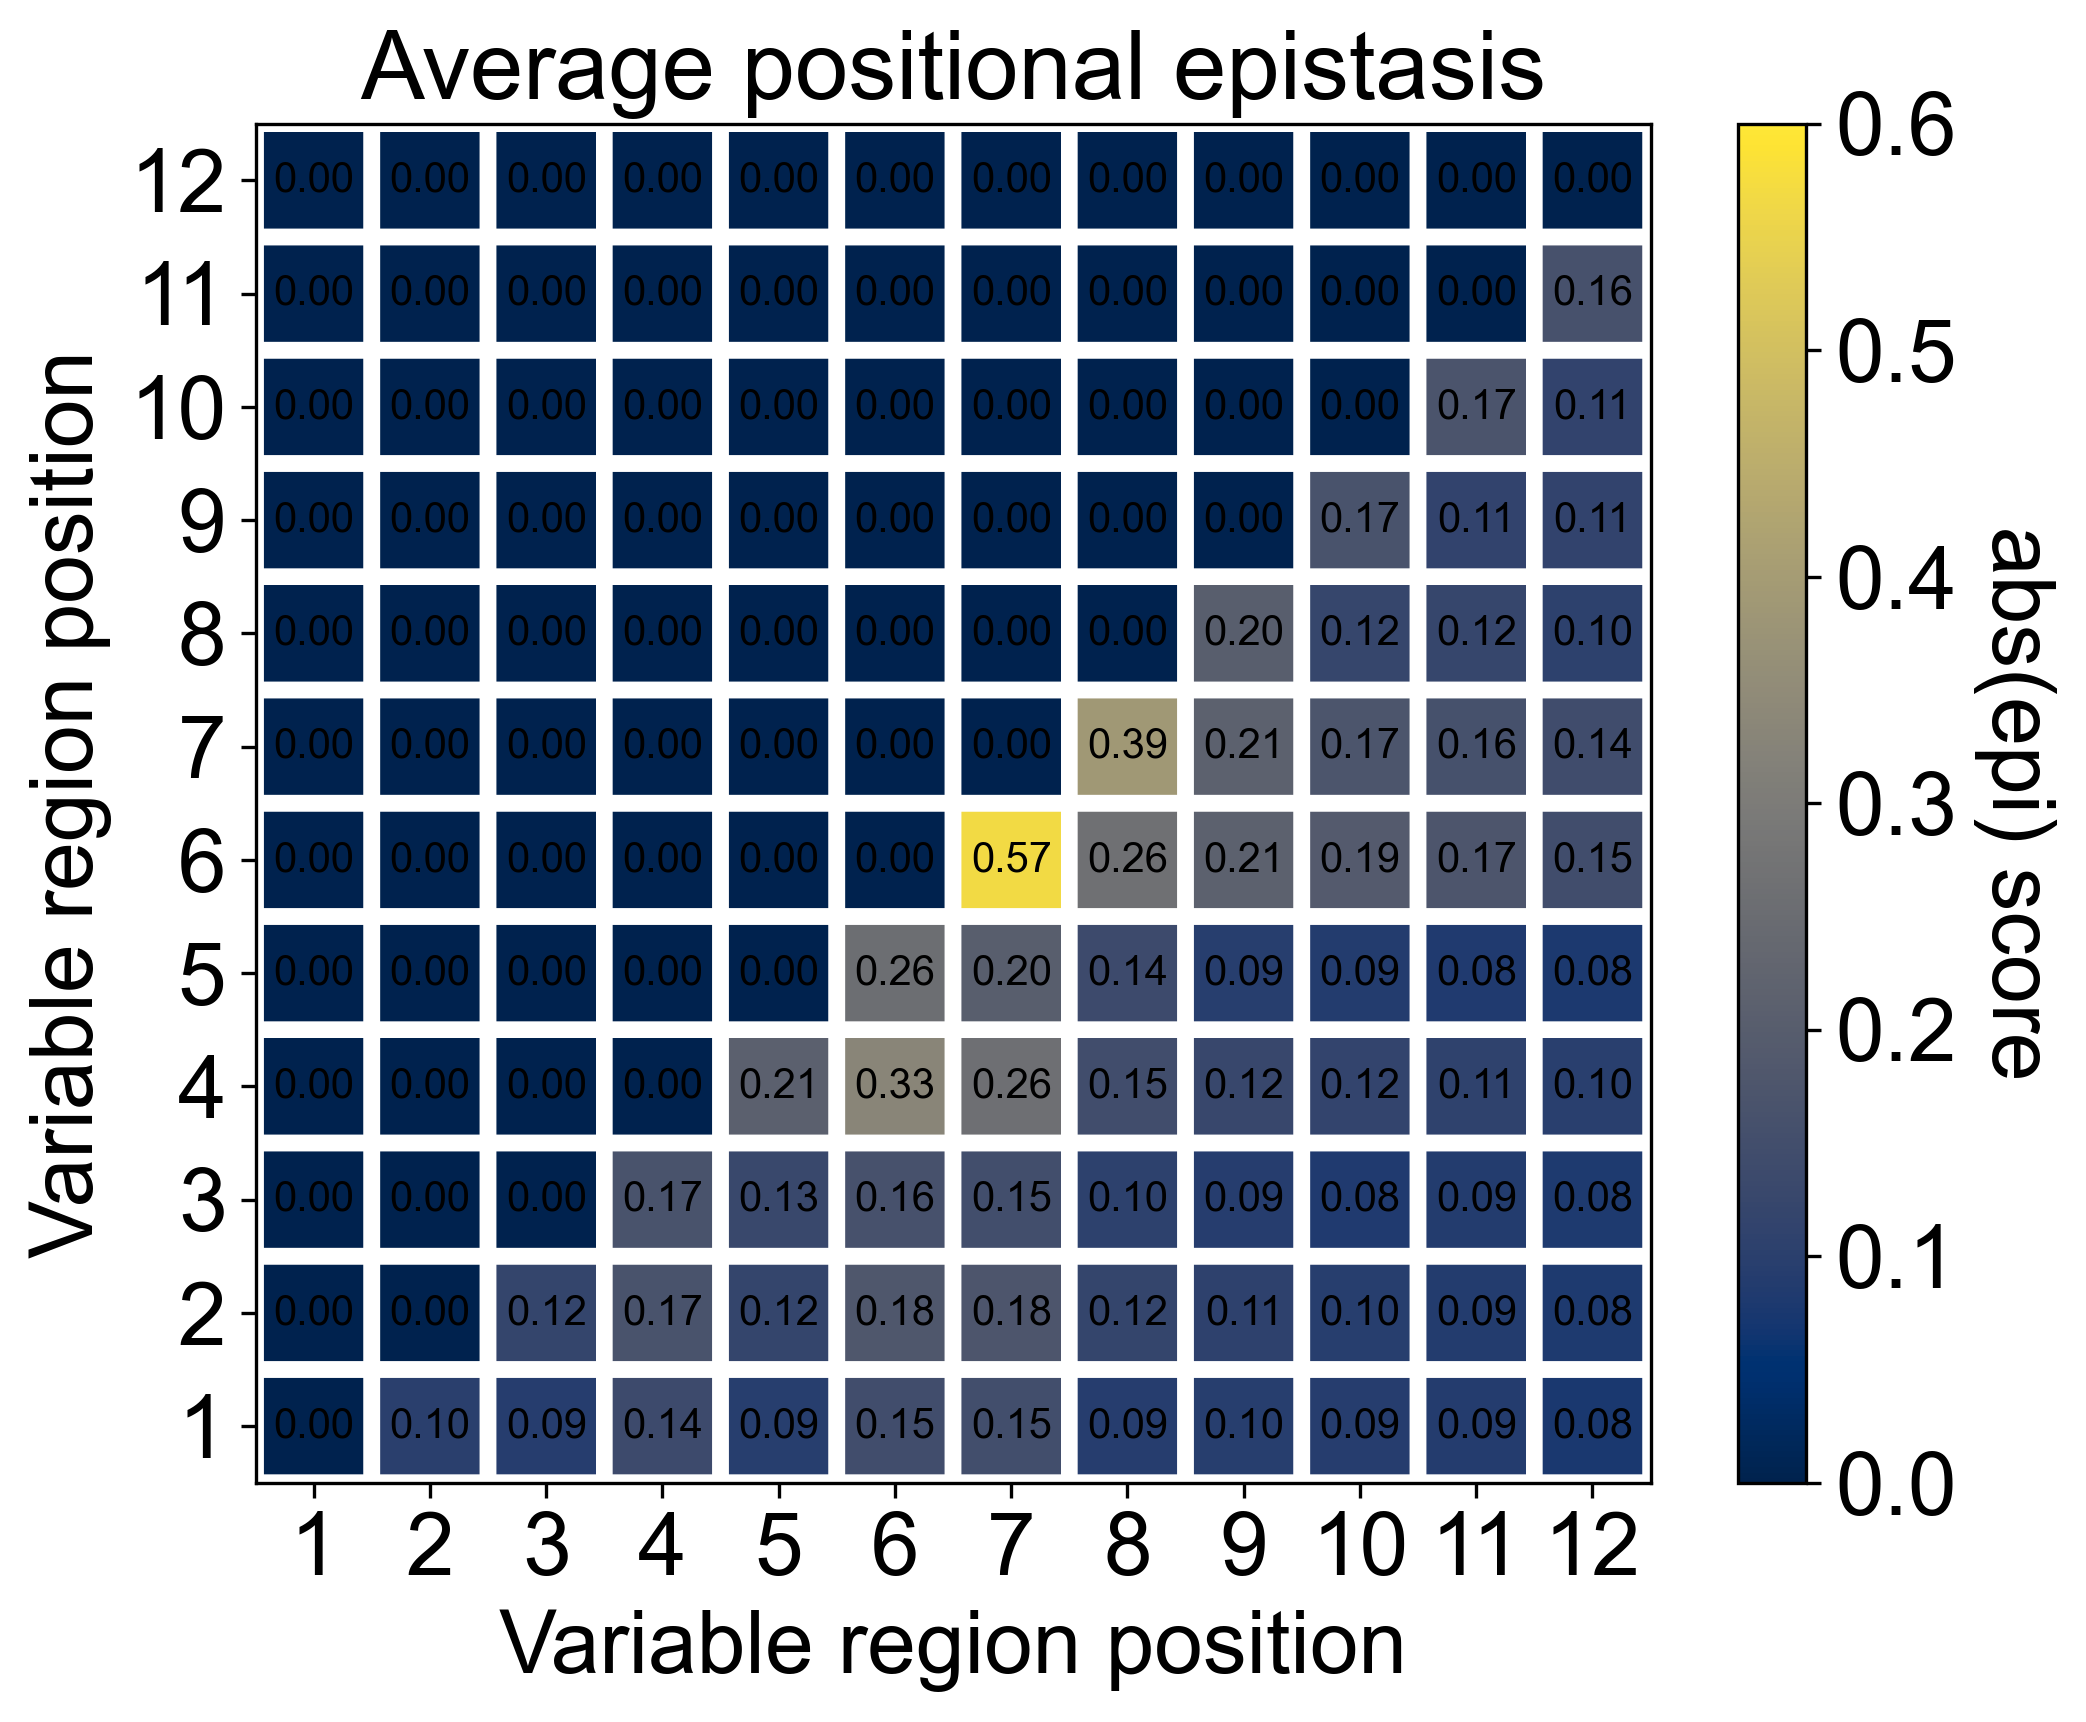

In [12]:
%matplotlib inline
from utils.Plotter import epistasis_bw_positions 
epistasis_bw_positions(epi, 'LazDEF_test_epi_plotting')

The values are not exactly the same as in Fig. 5f (the model and the number of peptides are different), but the overall trend is similar. As the number of peptides used for calculation increases, the abs(epi) values will look more and more like the ones from Fig. 5f because the sampling errors will go down. <br><br> Overlaing pairwise interactions over peptide sequence (like in Fig. 3e) is also easy:

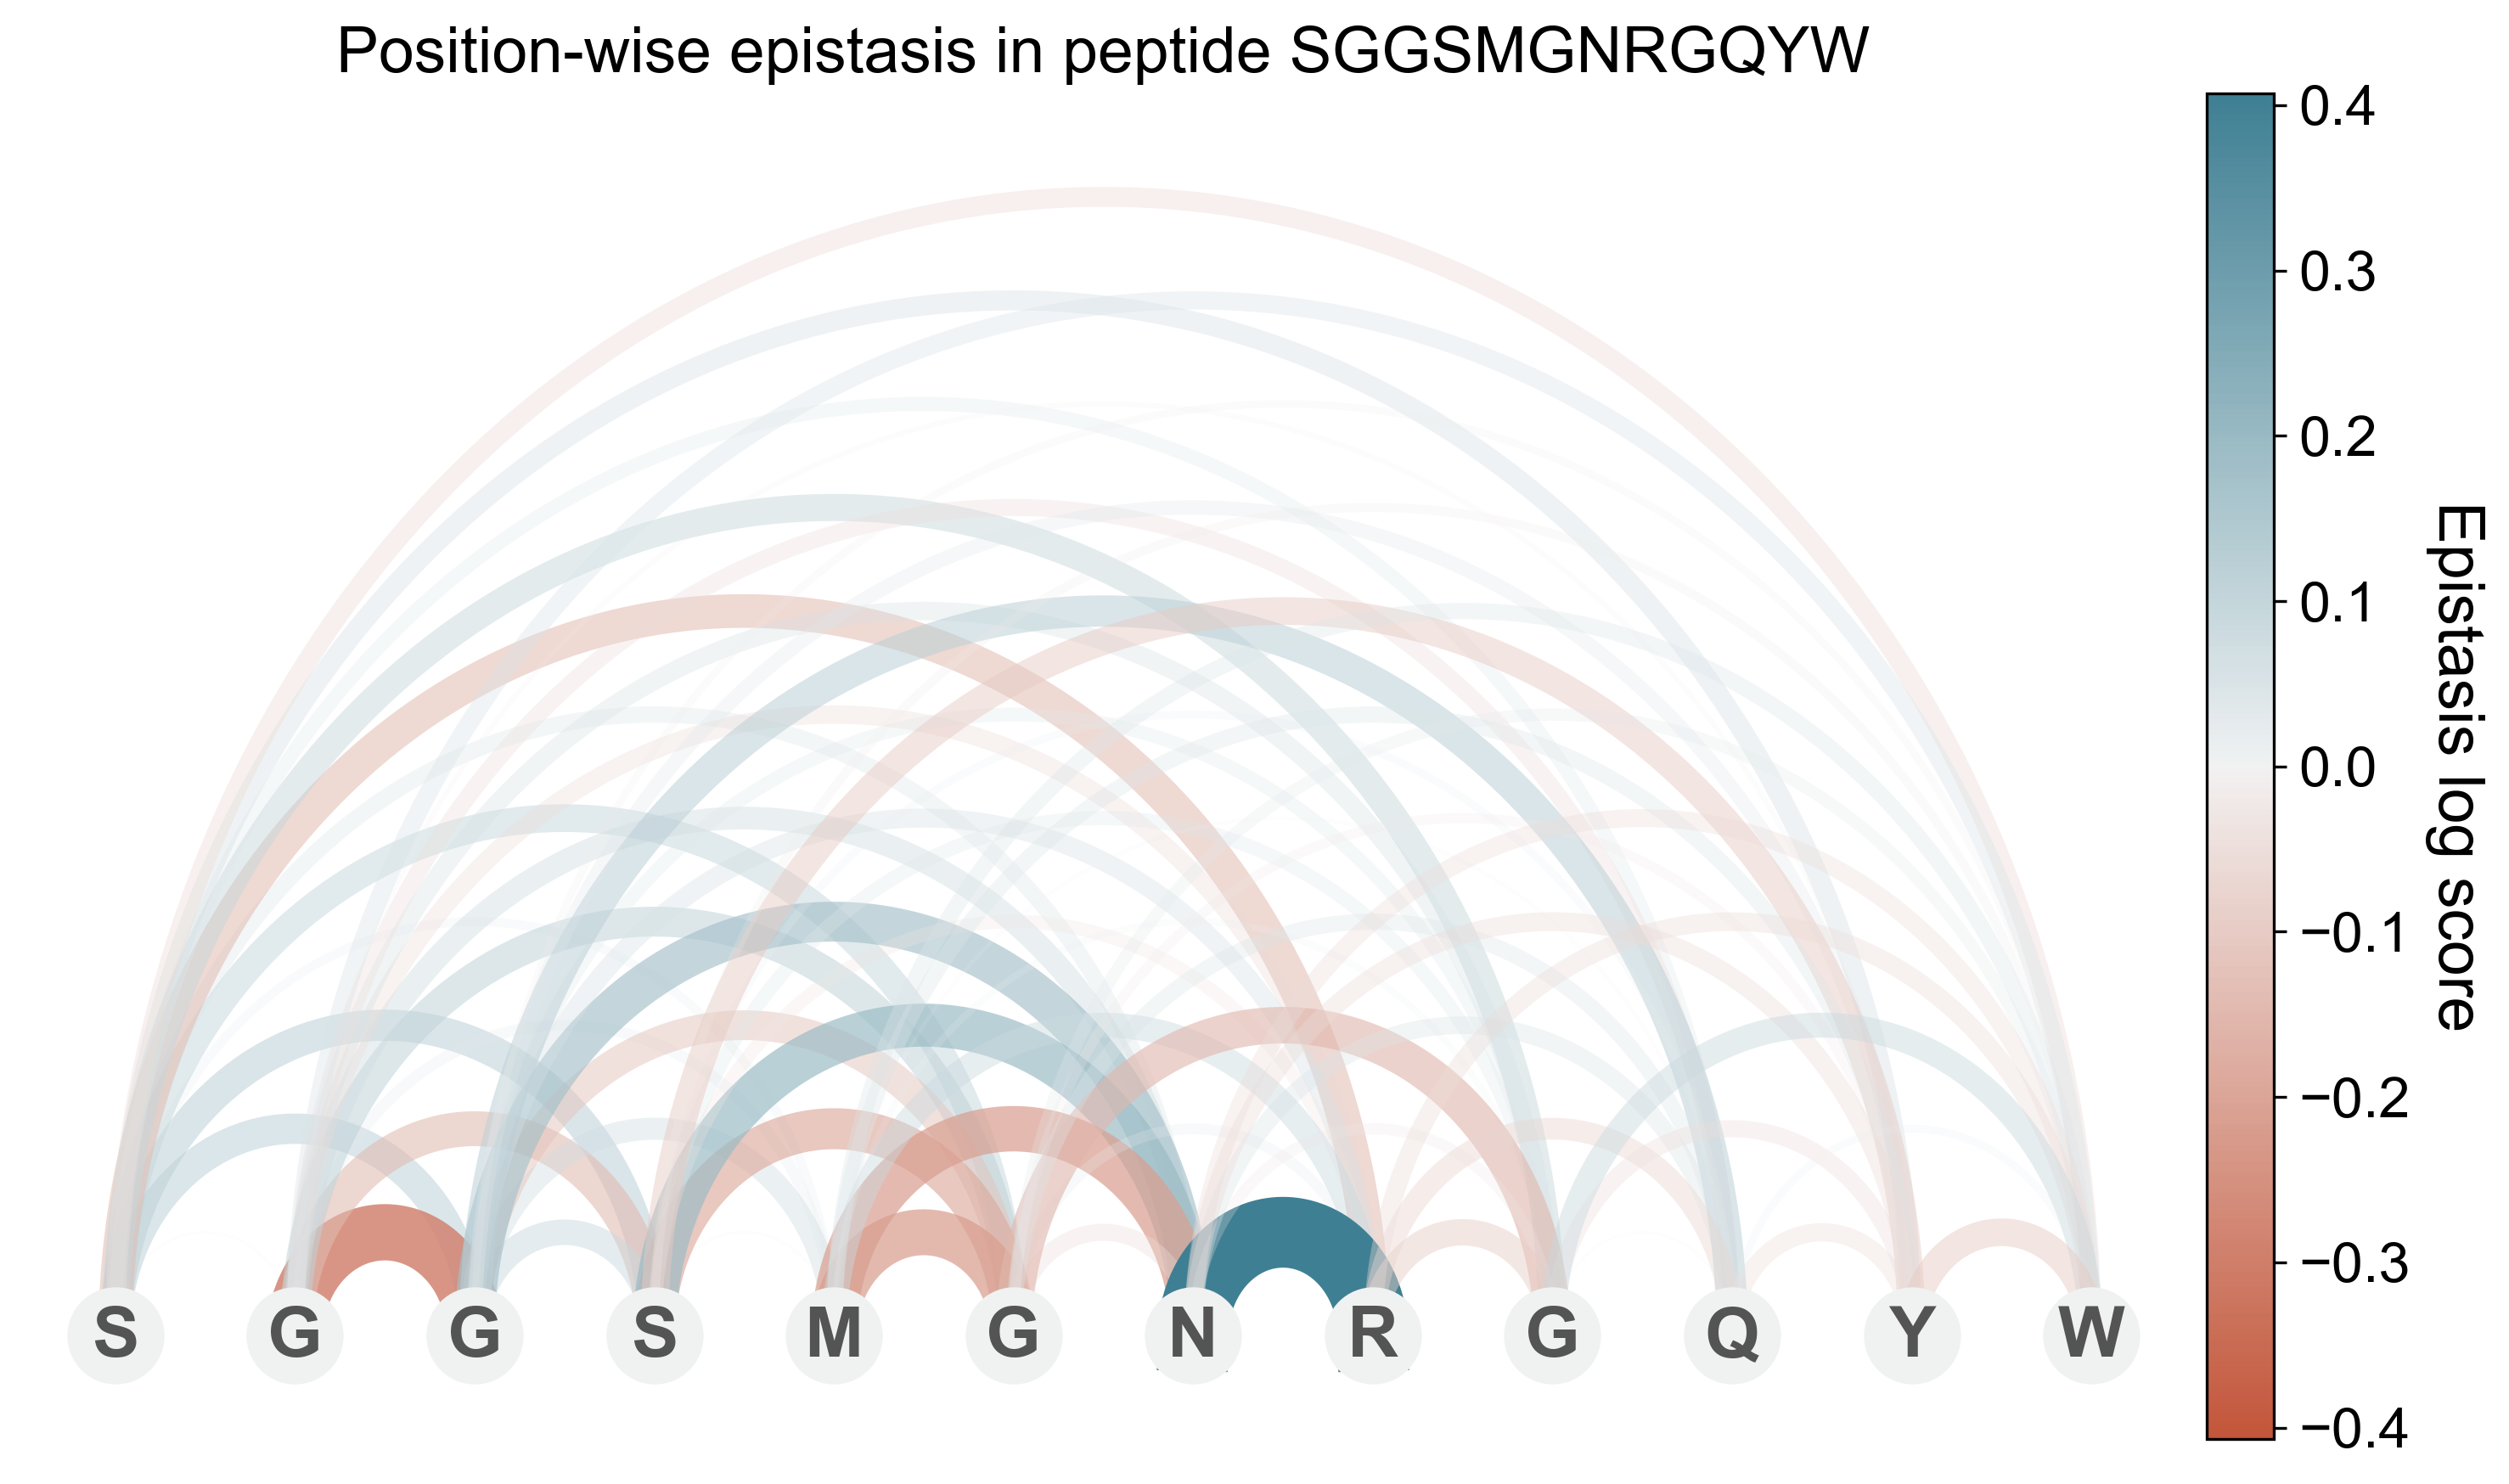

In [20]:
from utils.Plotter import pep_epistatic_interactions
pep_epistatic_interactions(epi, P_num_repr[34], 'LazDEF_epi_structure_overlay')

The magnitude of epi scores is fairly low - this is common for LazDEF substrates.

Finally, fully trained model weights used for the study are available as "../model/66_r5_ccn_v5_fully_trained_v2.h5" for LazDEF, and "../model/55_r6_cnn_v5_fully_trained.h5" for LazBF. Note that for LazBF, config will need to be modified, because the peptides have different dimensions (11x216 after featurization).

Model weights can be loaded:

In [23]:
cla.load_model_weights("66_r5_ccn_v5_fully_trained_v2.h5")

and used to interrogate the substrates. For example, to analyze P[34] peptide a bit more:

[INFO]: 3 routines appended to pipeline; current queue size: 3
[INFO]: SGGSMGNRGQYW X dataset shape: (240, 12)
[INFO]: SGGSMGNRGQYW y dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <numerical_repr> routine. . .
[INFO]: The operation took 0.0 s
[INFO]: SGGSMGNRGQYW X dataset shape: (240, 12)
[INFO]: SGGSMGNRGQYW y dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <factorize_X_datasets> routine. . .
[INFO]: The operation took 0.001 s
[INFO]: SGGSMGNRGQYW X dataset shape: (240, 12, 208)
[INFO]: SGGSMGNRGQYW y dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <predict_fitness> routine. . .
[INFO]: The operation took 0.071 s
[INFO]: SGGSMGNRGQYW X dataset shape: (240, 12, 208)
[INFO]: SGGSMGNRGQYW y dataset shape: None
[INFO]: -----------------------------------------------------------------


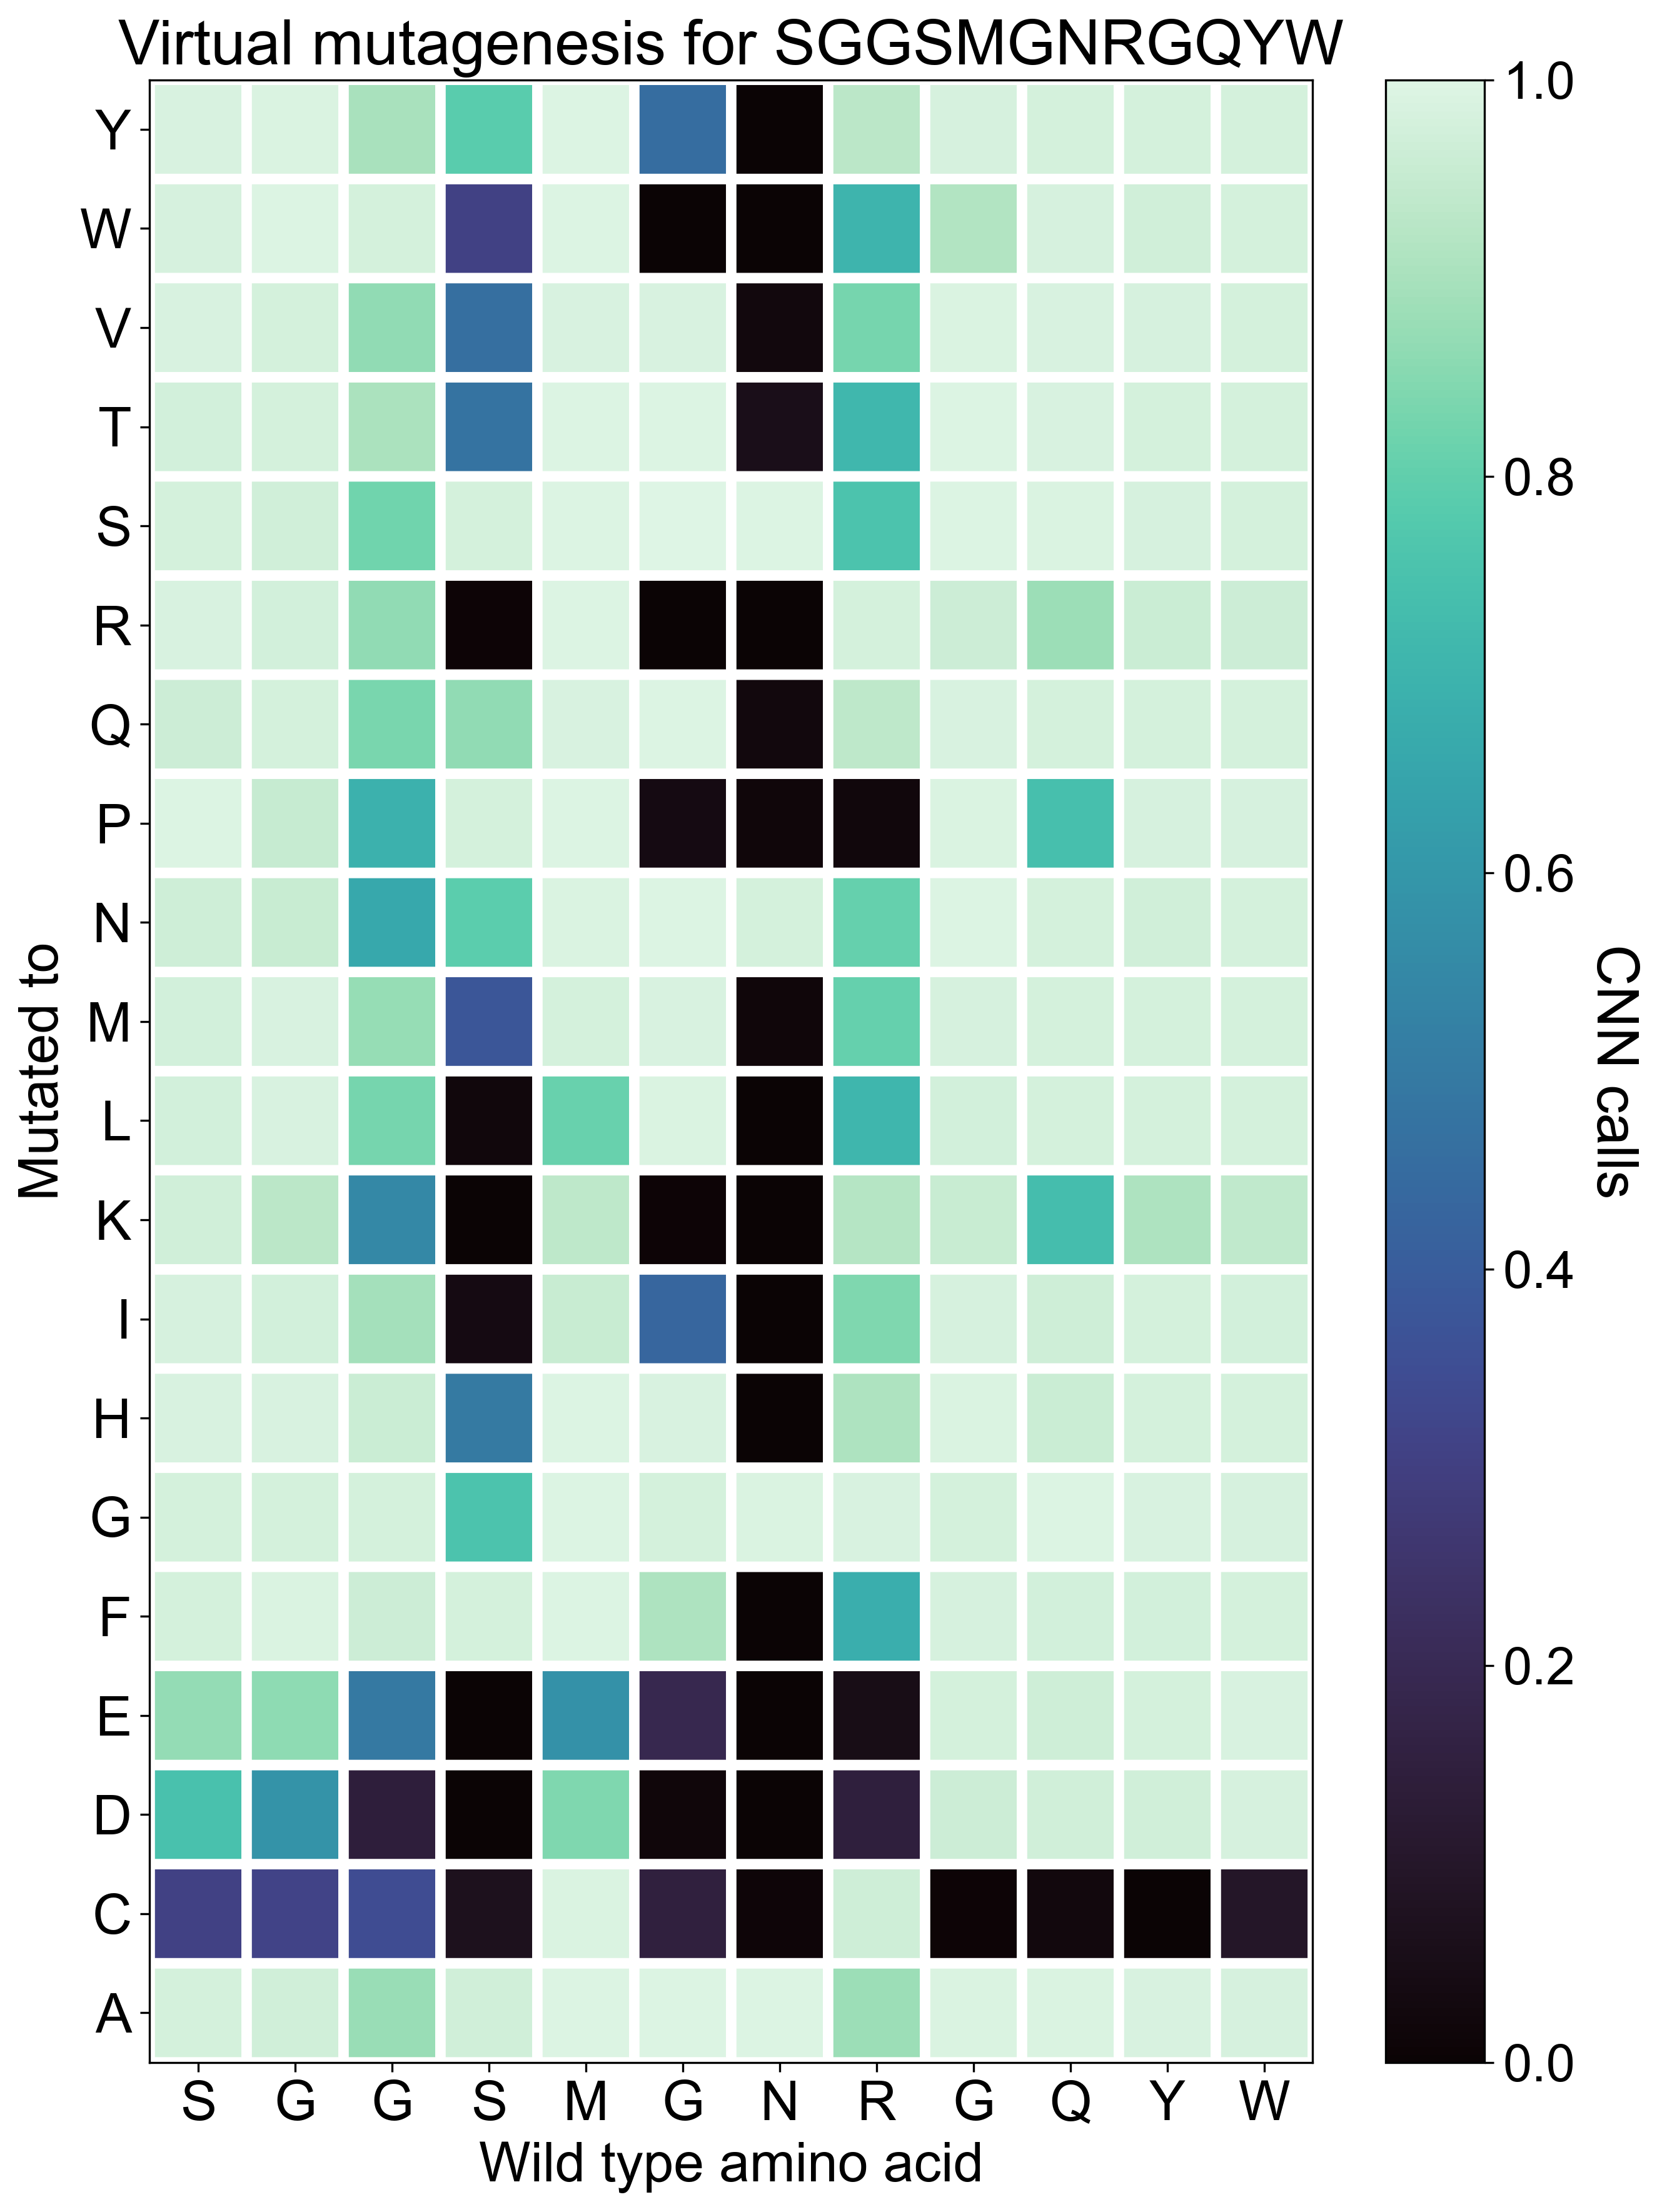

In [25]:
from interrogators.virtual_mutagenesis import virtual_saturation_mutagenesis
virtual_saturation_mutagenesis(P[34], cla, pre, pip)

This is "virtual saturation mutagenesis" done by the model on one of the random peptides from above. It seems that Ser4-Xaa5-Gly6-Cys7-Asn8 is the primary motif responsible for high modification efficiency in this case.